Lucy de Haan, Sean Sun, Faye Shipp, Ryan Wang

___________________________________________________________________________
Mining for Trends : An Exploratory Analysis of PLAICRAFT Data
-----------------------------------------
<img src='https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExdHFxdDV4ZXplZGRkeW4wbXp5ZXl0cHRiOHhrYmVvc2E0OWxhM2lxcCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/ZPQLVgoXJT7K8/giphy.gif' width='450'>

### **Introduction**

All data has been collected from players playing Minecraft on the PLAICRAFT server. PLAICRAFT is a research project by the Pacific Laboratoy of Artificial Intelligence at UBC to collect data on habits and tendencies of Minecraft players. Minecraft is a video game set in a universe where everything is cube shaped, wherein players mine for precious stones and gems whilst attemping to build structures and survive the elements.

We have been provided with two data sets: 
- `players.csv` tell us about a players age, experience, hours played, and other classifiers
- `sessions.csv` records logs of playtime start and stop times

In this project we aim to use the `players.csv` dataset to answer a predictive question through data analysis, visualization, and modelling.

**players.csv description**


This data set has 7 columns and 196 observations, here's what each column means:

| Column Name    | Description | Data Type |
| -------- | ------- | ------ |
| `experience`  | four experience levels (Beginner, Amateur, Regular, Pro, Veteran)    | Character |
| `subscribe` | whether the players subscribe to the newsletter (TRUE or FALSE)     |Logical|
| `hashedEmail`    | players' emails encrypted for confidenitality    |Character|
| `played_hours`  | total number of hours played to one decimal place    |Double Precision|
| `name` | name of players     |Character|
| `gender`   | sex (Male,Female,Non-Binary, Prefer not to Say, Agender, Two-Spirited)    |Character|
| `age`    | age in years, no decimal places for months      |Double Precision|

Based on the data set above, our question is as follows:

**Question:** Given a player's age and experience, can we predict how many hours of PLAICRAFT they will play?

___________________________________________________________________________
### **Methods and Results**
The question above is useful to the project managers in that it helps them find out which groups of people to target in their recruiting efforts in order to gather as much data as possible. To address this question, we'll apply both KNN and linear regression to the dataset and measure how they perform against each other by comparing their RMSPE values. This method is appropriate since we're trying to identify a relationship between three quantitative variables, one that is dependent (hours played) and two that are independent (experience level and age). Some assumptions required are multicollinearity, where independent variables are not highly correlated with each other, and errors in measurements between all the data points are normally distributed. Also, we assume that a relationship, either linear or non-linear, exists, as we conduct our analysis.

*Note:* All visualizations in this project will feature the colour `limegreen` both because it is easily distinguishable and because it honours the creeper, an infamous character in Minecraft.   


The first step is loading the tidyverse package which contains all the functions we will use to analyze the data.

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

The next step is reading the `players.csv` file from the web to this file so that it can be analyzed.

In [19]:
url_players <- "https://raw.githubusercontent.com/lucydehaan/Group-Project/refs/heads/main/players.csv"

players_raw <- read_csv(url_players)

head(players_raw)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Next, we want to tidy this data so that it is easier to wrangle. We will:


1. Convert all column names to lowercase using `tolower`and separate each word with an underscore
2. Convert data types. ex. from `< chr >` to `< fct >`
3. Remove `NA` values. (Since there are few `NA` values, we opt to remove them from the data set rather than replace them with the mean of their columns.)

In [5]:
players_tidy <- players_raw |>
    rename_with(tolower)|>
    mutate(gender = factor(gender)) |>
    mutate(age = as.integer(age)) |>
    rename(hashed_email = hashedemail) |>
    drop_na()

head(players_tidy)

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


The next step is specifically wrangling our data for the KNN regression model we want to apply. First we convert the experience column to factors. Then we order the factors from least to most experience which establishes a relationship between the classes and allows the model to apply regression based on the scalar values assigned to these variables (1,2,3,4,5). The last step is simply selecting the columns that are pertinent to our question.

In [6]:
data <- players_tidy |> mutate(experience = as.integer(factor(experience, 
                          levels = c("Beginner", "Amateur", "Regular", "Veteran", 
                                     "Pro"), ordered = TRUE))) |>
                        select(experience, played_hours, age)
head(data)

experience,played_hours,age
<int>,<dbl>,<int>
5,30.3,9
4,3.8,17
4,0.0,17
2,0.7,21
3,0.1,21
2,0.0,17


In [7]:
summary_data <- data |>
  summarize(
    min_experience = min(experience),
    max_experience = max(experience),
    mean_experience = mean(experience),
    min_played_hours = min(played_hours),
    max_played_hours = max(played_hours),
    mean_played_hours = mean(played_hours),
    min_age = min(age),
    max_age = max(age),
    mean_age = mean(age))

summary_data

min_experience,max_experience,mean_experience,min_played_hours,max_played_hours,mean_played_hours,min_age,max_age,mean_age
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,5,2.695876,0,223.1,5.904639,8,50,20.52062


Between the two, age appears to be the most reliable solo predictor as it ranges from 8 to 50 as opposed to experience which only ranges from 1 to 5. Thus we will first test linear and knn regression using age as the sole predictor, then we will add experience as the second predictor and assess whether it improves or worsens the regression models.


Now that we have a good idea of the ranges of the variables of interest, we can begin exploratory visualizations. First, let's visualize plot each predictor separately against the variable of interest : `played_hours`.

The means of age and experience don't appear to be heavily weighted toward the maximum or minimum, however the mean of `played_hours` is heavily weighted towards the mininum. This tells us that when creating our visualizations it is likely that we will have many points near 0 hours played, so in the visualization below we will adjust our y-axis scale accordingly.

Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


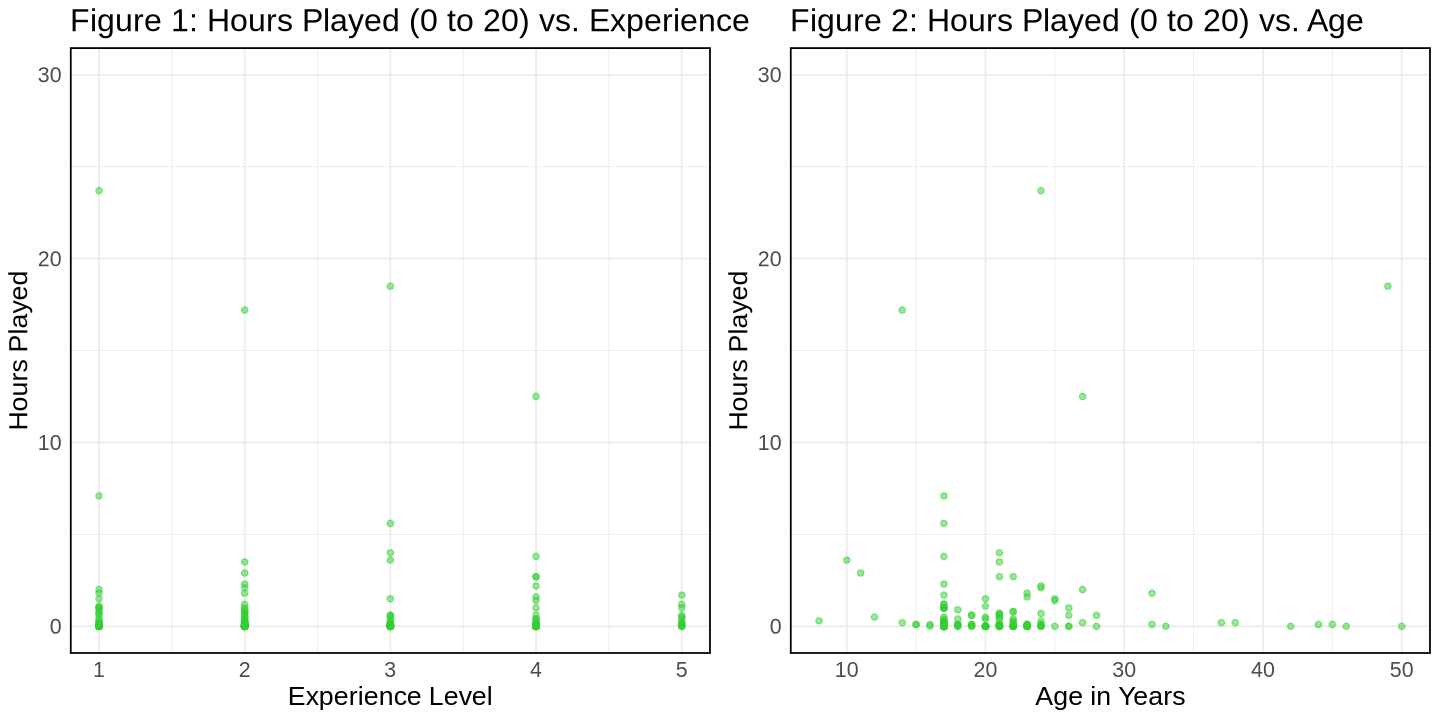

In [8]:
options(repr.plot.width = 12, repr.plot.height = 6)

experience_plot <- ggplot(data,aes(x = experience, y = played_hours)) +
    geom_point(alpha = 0.5, color = "limegreen") +
    theme_minimal() +
    labs(title = "Figure 1: Hours Played (0 to 20) vs. Experience",
         x = "Experience Level",
         y = "Hours Played") +
    scale_y_continuous(limits = c(NA, 30)) + #only show hours played from 0 to 30
    theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
          text = element_text(size = 16))

age_plot <- ggplot(data,aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.5, color = "limegreen") +
    theme_minimal() +
    labs(title = "Figure 2: Hours Played (0 to 20) vs. Age",
         x = "Age in Years",
         y = "Hours Played") +
    scale_y_continuous(limits = c(NA, 30)) + #only show hours played from 0 to 30
    theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
          text = element_text(size = 16))

plot_grid(experience_plot, age_plot, ncol = 2)

### KNN Regression
Since there does not appear to be a strong linear relationship in either of the predictors, we will start with KNN regression as opposed to linear regression. Here we split the tidy data and apply a KNN regression model to the training set. We chose to split it into 25% testing and 75% training because we have a relatively small data set with under 200 observations. We wanted to ensure we could maintain a sizeable testing set to adequately analyze the efficacy of our model at the end. Even though the data set is small, there are enough observations to use a 10-fold cross validation which could result in a more fine-tuned model.

In [9]:
 set.seed(69420)

data_split <- initial_split(data, prop = 0.75, strata = played_hours)  
data_train <- training(data_split)
data_test <- testing(data_split)

age_recipe <- data_train_recipe <- recipe(played_hours ~ age, data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

age_vfold <- vfold_cv(data_train, v = 10, strata = played_hours)

age_workflow <- workflow() |>
    add_recipe(age_recipe) |>
    add_model(age_spec)

gridvals <- tibble(neighbors = seq(from = 5, to = 80, by = 5))

age_results <- age_workflow |>
  tune_grid(resamples = age_vfold, grid = gridvals) |>  
    collect_metrics()

age_k_min <- age_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)

age_k_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
30,rmse,standard,19.66875,10,7.403761,Preprocessor1_Model06


This tells us that the k value with the lowest root mean squared error (RMSE) is k = 30, which we can now apply to the test data (`data_test`).

In [10]:
age_min <- age_k_min |>
         pull(neighbors)

age_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = age_min) |>
         set_engine("kknn") |>
         set_mode("regression")

age_best_fit <- workflow() |>
         add_recipe(age_recipe) |>
         add_model(age_best_spec) |>
         fit(data = data_train)

#evaluate the model
data_summary <- age_best_fit |>
          predict(data_test) |>
          bind_cols(data_test) |>
          metrics(truth = played_hours, estimate = .pred)
data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.90812871
rsq,standard,0.02363702
mae,standard,8.32823129


Now that we have collected summary statistics for our model before and after testing it on `data_test`, we can visualize the model.

Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_point()`).”


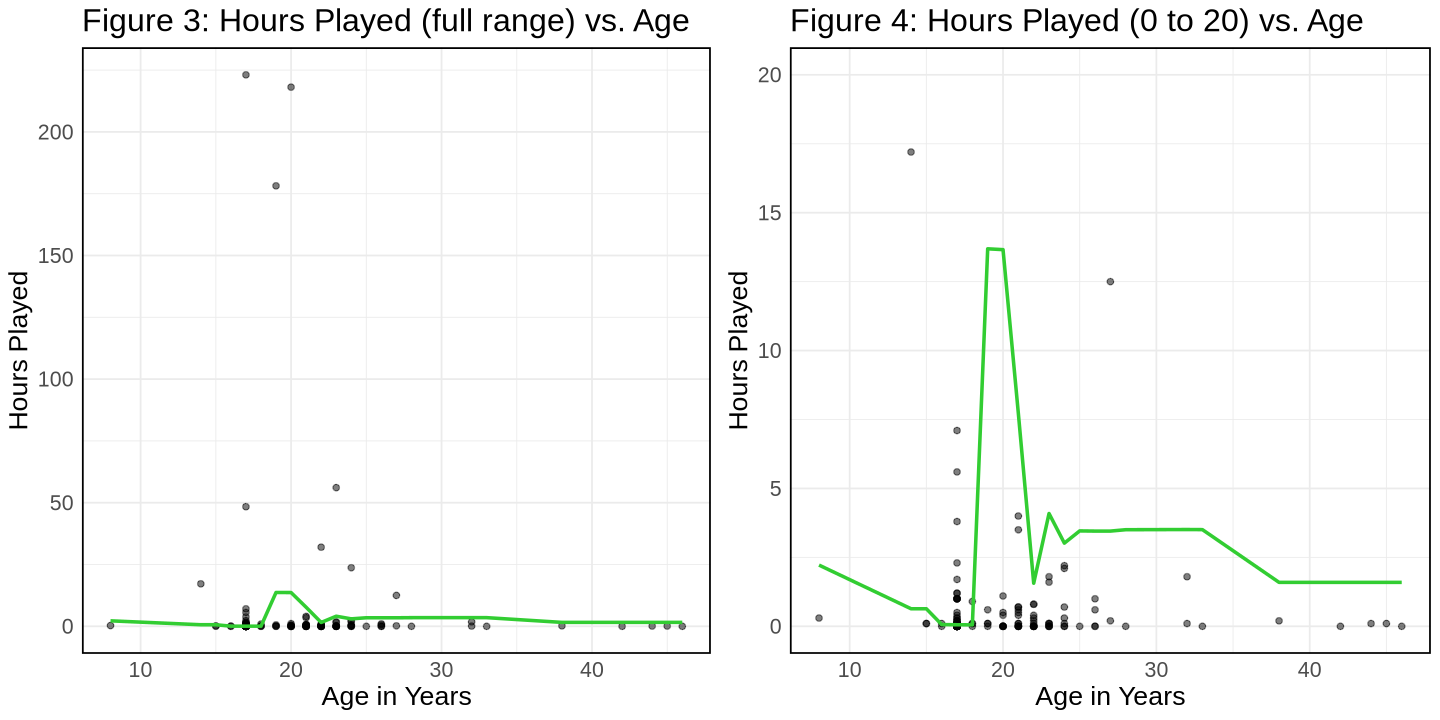

In [11]:
options(repr.plot.width = 12, repr.plot.height = 6)

age_preds <- age_best_fit |>
    predict(data_train)|>
    bind_cols(data_train)

marathon_plot <- age_preds |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    theme_minimal() +
    geom_line(data = arrange(age_preds, age),
        mapping = aes(x = age, y = .pred),
        color = "limegreen",
        linewidth = 1) +
    labs(x = "Age in Years",
         y= "Hours Played",
         title = "Figure 3: Hours Played (full range) vs. Age") +
    theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
          text = element_text(size = 16))

marathon_log_plot <- age_preds |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    theme_minimal() +
    scale_y_continuous(limits = c(NA, 20)) +
    geom_line(data = arrange(age_preds, age),
        mapping = aes(x = age, y = .pred),
        color = "limegreen",
        linewidth = 1) +
    labs(x = "Age in Years",
         y= "Hours Played",
         title = "Figure 4: Hours Played (0 to 20) vs. Age") +
    theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
          text = element_text(size = 16))

plot_grid(marathon_plot, marathon_log_plot, ncol = 2)

Since most of the data is concentrated near the x axis (at 0 hours played), we opted to add a plot that only shows 0 to 20 hours played to get a clearer picture of the model. 0 to 20 was chosen because it is a range that is inclusive of the trendline and the points around it while not leaving too much negative space.

The next step is to perform multivariable KNN regression using predictors age and experience.

In [12]:
set.seed(69420)

data_train_recipe <- recipe(played_hours ~ age + experience, data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#find optimal k
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

data_vfold <- vfold_cv(data_train, v = 10, strata = played_hours)

data_workflow <- workflow() |>
    add_recipe(data_train_recipe) |>
    add_model(data_spec)

gridvals <- tibble(neighbors = seq(from = 5, to = 80, by = 5))

k_data_results <- data_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>  
    collect_metrics()

k_data_min <- k_data_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)

k_data_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
35,rmse,standard,22.40272,10,6.64257,Preprocessor1_Model07


In [13]:
set.seed(69420)

k_min <- k_data_min |>
         pull(neighbors)

data_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

data_best_fit <- workflow() |>
         add_recipe(data_train_recipe) |>
         add_model(data_best_spec) |>
         fit(data = data_train)

#evaluate the model
data_summary <- data_best_fit |>
          predict(data_test) |>
          bind_cols(data_test) |>
          metrics(truth = played_hours, estimate = .pred)

data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.203320006
rsq,standard,0.001105794
mae,standard,9.823965015


We cannot produce a visualization for multi-predictor KNN regression because it would have to be 3D and 3D models are avoided in DSCI 100. However this model still produces useful statistics to be evaluated in the discussion.

## Linear Regression

Now, using the initial split of the dataset we used for the KNN-Regression model, we'll construct our linear regression model and compare errors between the models. 

In [14]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_recipe <- recipe(played_hours ~ age, data = data_train)

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = data_train)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
    11.1985      -0.2529  


From our fitted model, we obtain our intercept and slope. The equation for the straight line is then given by:

$$ \text{hours played} = 11.1985  -(0.2529 \cdot \text{age}) $$

This interpretation for this equation is that the model predicts that hours played start at 11.1985 at age zero, and that every one year increase in age nets a 0.2529 hour decrease in hours played. Note that this reasoning is given under the contraints of the dataset. 

Next, we'll calculate the RMSPE and compare it to one produced for our knn model.

In [15]:
lm_test_results <- lm_fit |>
  predict(data_test) |>
  bind_cols(data_test) |>
  metrics(truth = played_hours, estimate = .pred)

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.587979372
rsq,standard,0.007369871
mae,standard,9.898088526


Finally, we'll visualize our linear regression model by calculating the minimum and maximum values of our set and connecting it with a straight line.

Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_point()`).”


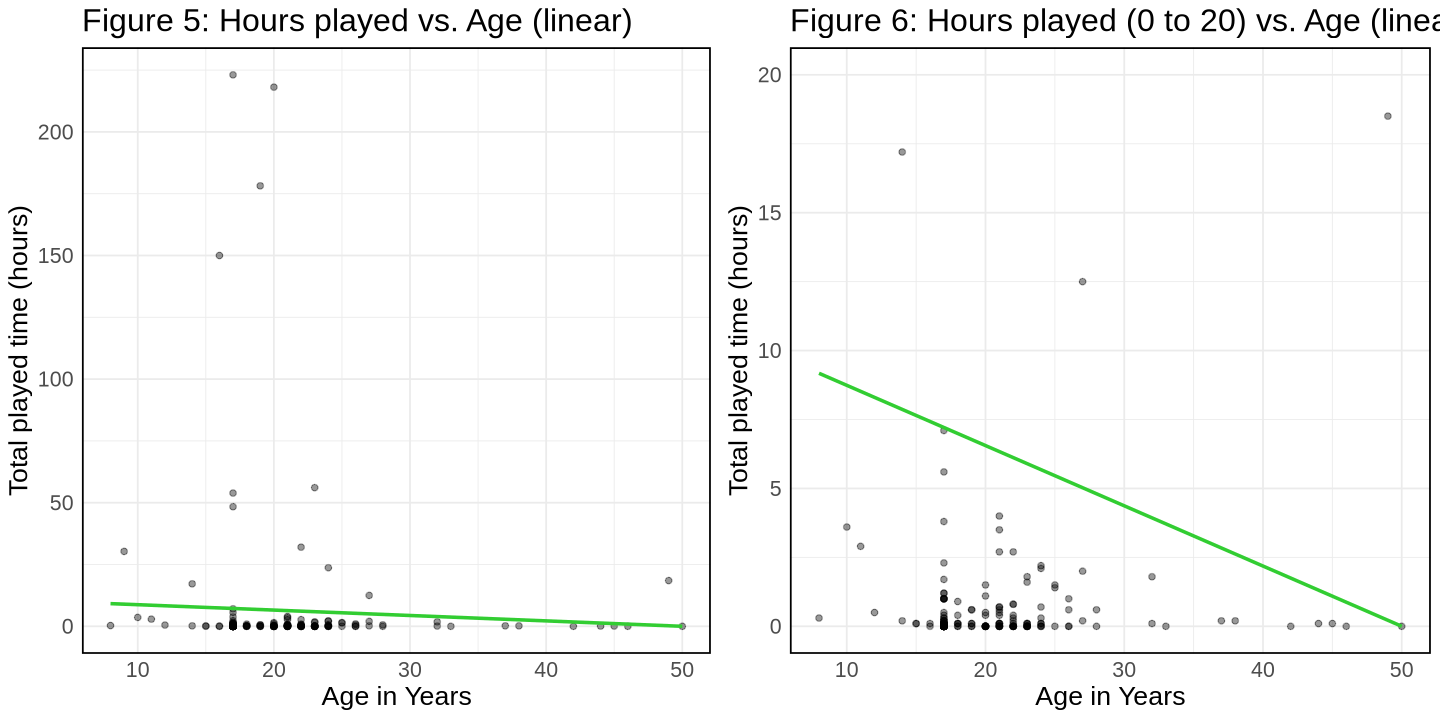

In [21]:
options(repr.plot.width = 12, repr.plot.height = 6)

hours_prediction_grid <- tibble(
    age = c(
        data |> select(age) |> min(),
        data |> select(age) |> max()
    )
)

hours_pred <- lm_fit |>
  predict(hours_prediction_grid) |>
  bind_cols(hours_prediction_grid) |>
    mutate(.pred = pmax(.pred, 0)) # keeps regression line above 0 (cannot have negative hours played)

linear_plot <- ggplot(data, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = hours_pred,
            mapping = aes(x = age, y = .pred),
            color = "limegreen",
            linewidth = 1) +
  theme_minimal() + 
  labs(x = "Age in Years",
        y = "Total played time (hours)",
        title = "Figure 5: Hours played vs. Age (linear)") +
  theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
        text = element_text(size = 16))


linear_plot_range <- ggplot(data, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = hours_pred,
            mapping = aes(x = age, y = .pred),
            color = "limegreen",
            linewidth = 1) +
  theme_minimal() + 
    labs(x = "Age in Years",
         y = "Total played time (hours)",
         title = "Figure 6: Hours played (0 to 20) vs. Age (linear)") +
  scale_y_continuous(limits = c(NA, 20)) +
  theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
          text = element_text(size = 16))

plot_grid(linear_plot, linear_plot_range, ncol = 2)

Again, a plot with a smaller range of hours played (0 to 20) was added for comparison and ease of visualization of the linear regression model.

Next we will add `experience` as a predictor and collect statistics on the new multivariable linear regression model.

In [17]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_recipe2 <- recipe(played_hours ~ age + experience, data = data_train)

lm_fit2 <- workflow() |>
  add_recipe(lm_recipe2) |>
  add_model(lm_spec) |>
  fit(data = data_train)

lm_fit2

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age   experience  
    10.1370      -0.2474       0.3590  


From our fitted model, we obtain our intercept and slope. The equation for the straight line is similar to the single predictor equation, with one more term added for experience:    
$$ \text{hours played} = 10.1370 -(0.2474 \cdot \text{age}) +(0.3590 \cdot \text{experience})$$

This model is still linear but with the two vectors of age and experience, it will be a 3D plane instead of a 2D line.

In [18]:
lm_test_results2 <- lm_fit2 |>
  predict(data_test) |>
  bind_cols(data_test) |>
  metrics(truth = played_hours, estimate = .pred)

lm_test_results2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.632918810
rsq,standard,0.004104868
mae,standard,9.940558674


Similarly to multivariable KNN regression, we cannot visualize this model without producing a 3D model. However the statistics will be useful for comparison.

___________________________________________________________________________
### **Discussion**

**Comparison Between Simple and Multivariable Regression Models**

In terms of KNN regression, age as the single predictor returned an RMSPE value of 23.91 whereas when experience was added to the recipe, the RMSPE lowered to 23.20. 

As for linear regression, age as the sole predictor gave an RMSE of 22.59 whereas when experience was added to the recipe, the RMSE increased slightly to 22.63.

Overall the negligible difference (less than 1) between using simple regression and multivariable regression indicates that both predictors are equally poor at predicting hours played. If experience level was a more accurate predictor than age, we would have seen a significant decrease in RMSPE. Inversely, if experience level was a worse predictor in age, we would have seen an increase in RMSPE.

Considering the scale of hours played ranged from 0 to 223.1, all RMSPE's are very large proportionally to the range, indicating a poor model. This was partly expected going into the project since we started with fewer than 200 observations and the observations were unevenly distributed: largely centered around 0 hours played with a mean of 5.9 or 5 hours and 54 minutes.

**Comparison between our Linear Regressison and KNN Regression Models Overall**    
The best calculated RMSPE values between our KNN and linear regression models are 23.20 and 22.59 respectively. Given RMSPE as our metric, our linear regression model has better performance in this particular case. However, given the constraints of our dataset, we cannot confidently judge which model is better for modeling the relationship in this case. For example, the linear model performing better contradicts our initial analysis of the data that there were no strong linear relationships. Linear regression is only supposed to be better fitted than KNN regression when there is an observable linear relationship between variables (Timbers et al., 2024).

Currently, both models are limited by the lack of variety of data relevant to the analysis, which may create large random error in the model. As for the method itself, in the event that the relationship is non-linear, the model may not capture such a relation in a sufficiently accurate manner. It appears that most of the highest time played occurs in roughly the ages 15-25 range. Also, majority of points seem be concentrated at around zero hours played. 

**Impact and Future Discussions**

Overall, it would be interesting to perform another analysis in a few months when the study has collected more data. We found the small data set was not conducive to regression models but was fairly responsive to simpler analyses such as basic visualizations performed at the beginning of the project and the many visualizations produced in the Individual Project Planning Stage.

One of the tricky parts of the project was deciding whether or not to exclude outliers, for example the participant who contributed 223.1 hours of playing time. However in the end we decided to keep as many data points as we could (`NA` values excluded), because we were working with an already small data set. Additionally, since the the players of interest to the PLAICRAFT research group are those who contribute many hours, it seemed counterintuitive to eliminate them from our analysis.

These findings hinted at possible relationships between age and hours played. The KNN regression model showed that ages between 15-25 were likely to contribute the most data. The linear regression model (limited by it's linearity) showed that younger ages tended to contribute more data. The conclusion from the KNN model is more useful to the PLAICRAFT project as it provides a specific demographic for the researchers to target. The linear conclusion implies that babies are likely to contribute the most amount of data, which is nonsensical. The KNN model being more rational than the linear model indicates that lower RMSPE is not always the definite indicator of the best model. There are instances where human discernment comes into play. For example, knowing that babies do not play video games, and that users may not always input correct registration information (how would a baby register for PLAICRAFT anyways?).

Some future questions we have are:

- Could we evaluate consistency/reccurence as well as total time played? For instance, a regular contributor could be more valuable than a contributor who plays one long session and never comes back.
- Is gender a factor in hours played? If females contribute more on average, but males are easier to recruit, is it statistically beneficial to put more effort into recruiting men or women?
- Experience level is quite a vague metric. Is there another metric that could be more accurate such as years of Minecraft played or could players be classed based on a Minecraft quiz?
- How else could we class players?
- Could we use more recently learned DSCI 100 techniques such as clustering and bootstrapping to discover groups/niches of PLAICRAFT players?


___________________________________________________________________________
### **References**

Introductory GIF: https://giphy.com/gifs/zombie-pit-ensues-ZPQLVgoXJT7K8

Textbook: Timbers, T., Campbell, T., & Lee, M. (2024). Data Science: A First Introduction. In    datasciencebook.ca. CRC Press. https://datasciencebook.ca/


